<a href="https://colab.research.google.com/github/willfinnigan/Seven_enzyme_biotransformation_2019/blob/master/CAR_only.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

![CAR](https://github.com/willfinnigan/Seven_enzyme_biotransformation_2019/raw/master/figures/CAR_all.jpg)

# Setup Notebook

In [0]:
#@title Install and import packages {display-mode: "form"}
!pip install -q kinetics==1.1.5

import kinetics
import matplotlib.pyplot as plt
import matplotlib as mpl
import pandas as pd
import numpy as np
from IPython.display import Markdown, display

%matplotlib inline
%config InlineBackend.figure_format ='retina'

data_url = 'https://github.com/willfinnigan/Seven_enzyme_biotransformation_2019/blob/master/experimental_data.xlsx?raw=true'

plt.style.use('seaborn-whitegrid')
mpl.rcParams['figure.figsize'] = (15,10)
mpl.rcParams['lines.linewidth'] = 1
mpl.rcParams['lines.markersize']  = 8 
mpl.rcParams['axes.linewidth'] = 1.5
mpl.rcParams['font.size'] = 22

In [0]:
#@title Functions for plotting {display-mode: "form"}
substrate_colours = {"Ester" : "#8C0000",
                     "Acid" : "#000090",
                     "Aldehyde" : "#068400",
                     "Alcohol" : "#CA6602"}

substrate_symbols = {"Ester" : "o",
                     "Acid" : "s",
                     "Aldehyde" : "^",
                     "Alcohol" : "v"}


def setup_graph(y_max=4000, x_max=240):
    plt.xlabel('Time (mins)')
    plt.ylabel("μM substrate")
    plt.ylim(bottom=0)
    plt.xlim(left=0)
    plt.xticks(np.arange(0, x_max+1, 30))
    plt.yticks(np.arange(0, y_max+1, 500))
    
    
def add_ua_model_to_graph(substrates_to_add, dataframes,
                          substrate_colours=substrate_colours):
    
    for substrate in substrates_to_add:
        df = dataframes[substrate]
    
        time = df['Time'].tolist()
        high = df['High'].tolist()
        low = df['Low'].tolist()
        mean = df['Mean'].tolist()
        
        hight_line = plt.plot(time, high, color=substrate_colours[substrate], linestyle="--", linewidth = 0.5)
        low_line = plt.plot(time, low,  color=substrate_colours[substrate], linestyle="--", linewidth = 0.5)
        mean_line = plt.plot(time, mean,  color=substrate_colours[substrate], linewidth = 1.5, label=substrate)
        
    plt.legend(ncol=4)
    
        
def add_experimental_data_to_graph(substrates_to_add, exp_data_df,
                                   substrate_colours=substrate_colours,
                                   substrate_symbols=substrate_symbols):
    time_data = exp_data_df["Time"]
    for substrate in substrates_to_add:
        for column in exp_data_df:
            if substrate in column:
                data_to_plot = exp_data_df[column]
                plt.scatter(time_data, data_to_plot,
                            edgecolors="black",
                            c=substrate_colours[substrate],
                            marker=substrate_symbols[substrate])
                

# CAR alone

In [0]:
#@title CAR reaction no inhibition {display-mode: "form"}
car = kinetics.Three_seq_irr_car(kcat="car_kcat",
                                 kma="car_km_atp", kmb="car_km_acid", kmc="car_km_nadph", kia="car_kia_atp",
                                 enz='car', a='ATP', b='Acid', c='NADPH',
                                 substrates=["Acid", "ATP", "NADPH"],
                                 products=["Aldehyde", "PPi", "NADP+", "AMP"])

car.parameter_bounds = {"car_km_atp": (72, 128),
                        "car_kia_atp": (6, 74),
                        "car_km_acid": (1180, 1820),
                        "car_km_nadph": (22, 38),
                        "car_kcat": (180, 220)}

In [0]:
# Define the model
model = kinetics.Model(logging=False)
model.append(car)

# Set the initial species concentrations in the model (in uM)
model.reaction_species.update({"car" : (1, 0.05),
                               "Acid" : (4000, 0.05),
                               "ATP" : (8000, 0.05),
                               "NADPH" : (5000, 0.05)})

# Set the model time: model.set_time(start, end, steps)
model.set_time(0, 240, 1000)
model.setup_model();

# Run the model as an uncertainty analysis
ua = kinetics.UA(model, num_samples=500, quartile_range=95, logging=True)
ua.run_standard_ua()

self.problem, self.samples and self.parsed_samples set by lhc
running all models


100%|██████████| 500/500 [00:02<00:00, 172.93it/s]


samples run, model outputs saved in self.output
quartiles calculated, saved in self.quartile_output
Quartiles for each substrate saved to self.substrate_dataframes


![CAR](https://github.com/willfinnigan/Seven_enzyme_biotransformation_2019/raw/master/figures/CAR_alone.jpg)

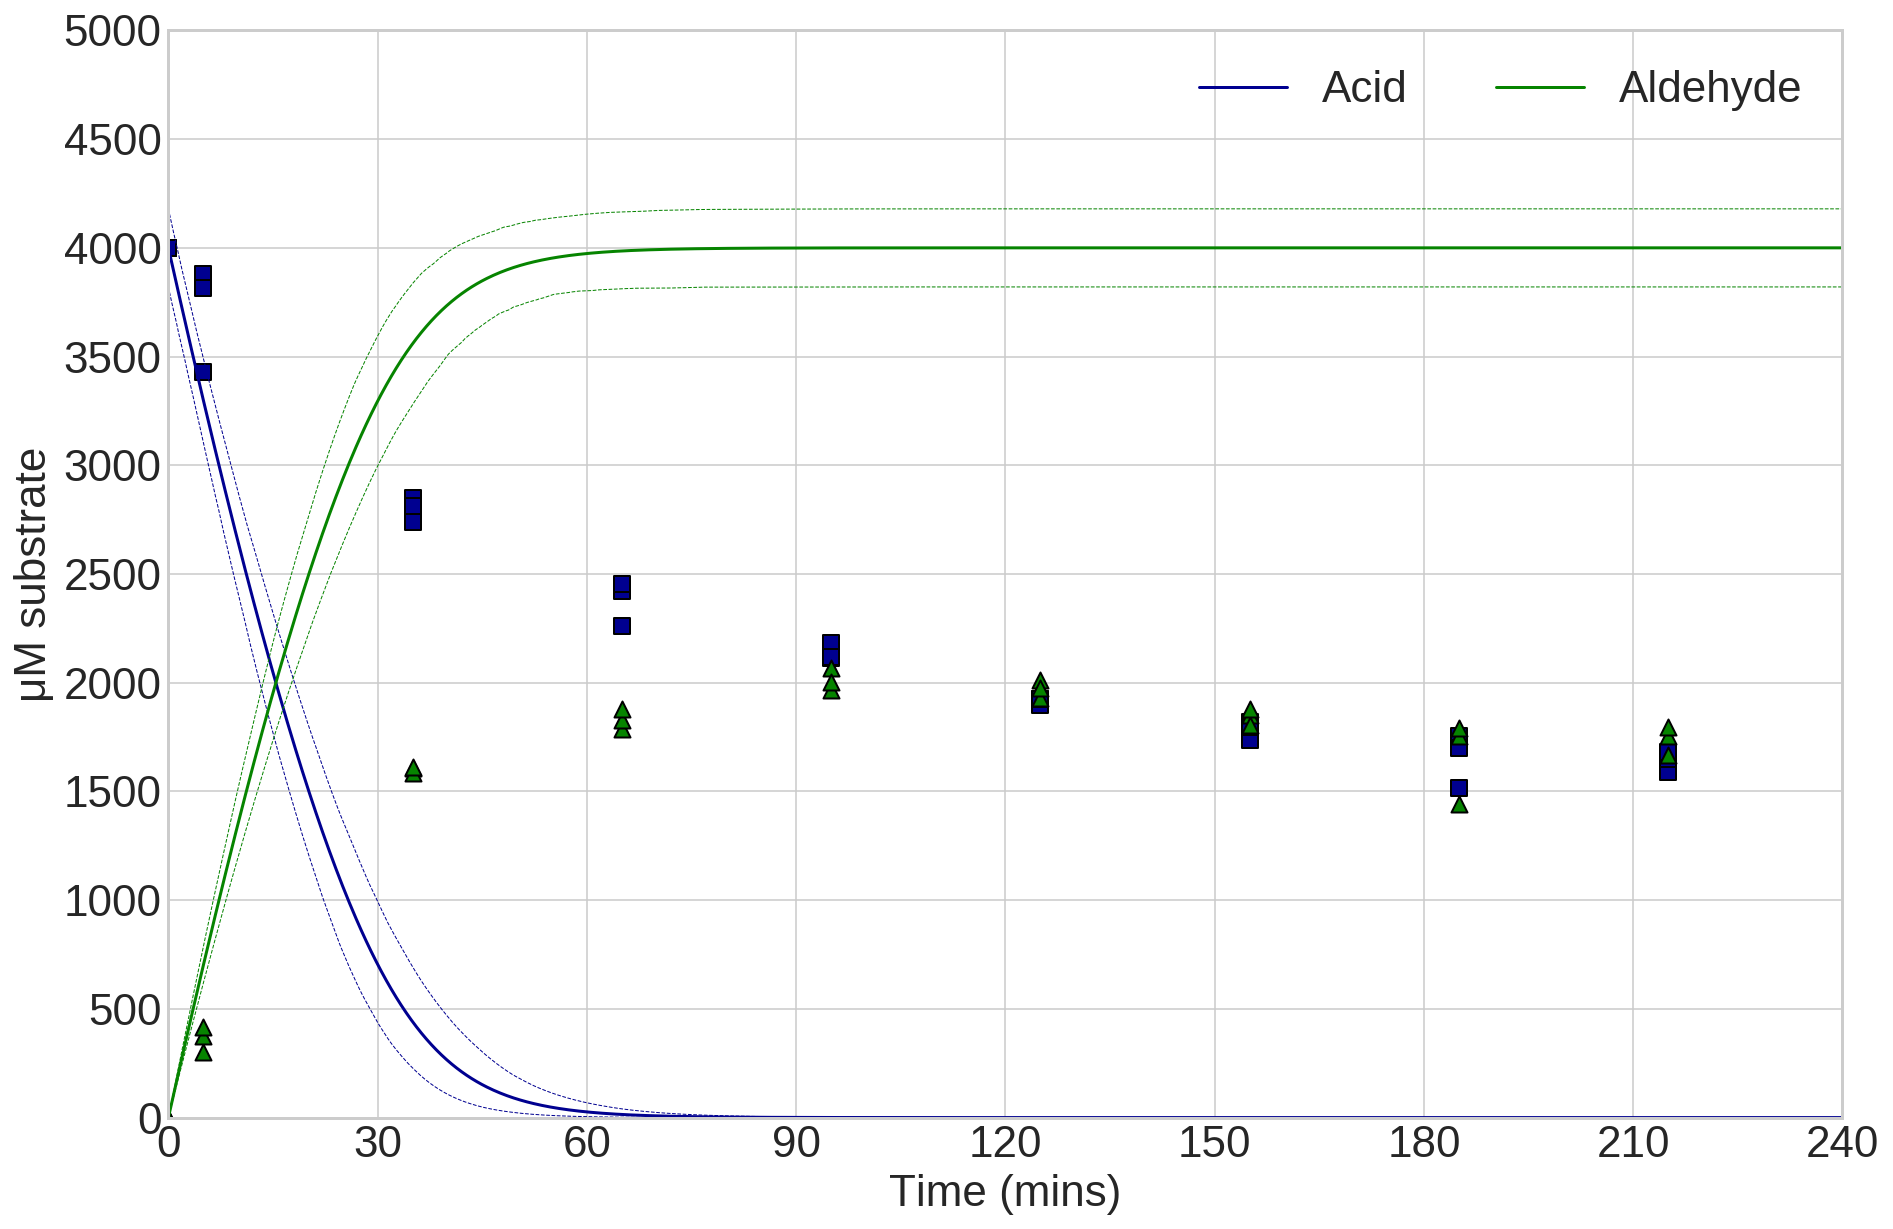

In [0]:
# Plot the model vs experimental data
substrates = ["Acid", "Aldehyde"]
setup_graph(y_max=5000, x_max=240)
lines = add_ua_model_to_graph(substrates, ua.substrate_dataframes)
exp_data = pd.read_excel(data_url, 'car_only')
add_experimental_data_to_graph(substrates, exp_data)
plt.show()

In [0]:
#@title CAR reaction with inhibition {display-mode: "form"}
car = kinetics.Three_seq_irr_car(kcat="car_kcat",
                                 kma="car_km_atp", kmb="car_km_acid", kmc="car_km_nadph", kia="car_kia_atp",
                                 enz='car', a='ATP', b='Acid', c='NADPH',
                                 substrates=["Acid", "ATP", "NADPH"],
                                 products=["Aldehyde", "PPi", "NADP+", "AMP"])

car.add_modifier(kinetics.CompetitiveInhibition(km="car_km_nadph", ki="car_ki_nadp+", i="NADP+"))
car.add_modifier(kinetics.CompetitiveInhibition(km="car_km_atp", ki="car_ki_adp", i="ADP"))
car.add_modifier(kinetics.CompetitiveInhibition(km="car_km_atp", ki="car_ki_amp", i="AMP"))
car.add_modifier(kinetics.CompetitiveInhibition(km="car_km_acid", ki="car_ki_ppi_acid", i="PPi"))
car.add_modifier(kinetics.MixedInhibition(kcat="car_kcat", km="car_km_atp",
                                          ki="car_ki_ppi_atp", alpha="car_alpha_ppi_atp", i="PPi"))

car.parameter_bounds = {"car_km_atp": (72, 128),
                        "car_kia_atp": (6, 74),
                        "car_km_acid": (1180, 1820),
                        "car_km_nadph": (22, 38),
                        "car_kcat": (180, 220),
                        "car_ki_nadp+": (127, 159),
                        "car_ki_ppi_acid": (260, 420),
                        "car_ki_adp": (7000, 15000),
                        "car_ki_amp": (8200, 11800),
                        "car_ki_ppi_atp": (120, 320),
                        "car_alpha_ppi_atp": (0, 5.3)}

In [0]:
# Define the model
model = kinetics.Model(logging=False)
model.append(car)

# Set the initial species concentrations in the model (in uM)
model.reaction_species.update({"car" : (1, 0.05),
                               "Acid" : (4000, 0.05),
                               "ATP" : (8000, 0.05),
                               "NADPH" : (5000, 0.05)})

# Set the model time: model.set_time(start, end, steps)
model.set_time(0, 240, 1000)
model.setup_model();

# Run the model as an uncertainty analysis
ua = kinetics.UA(model, num_samples=500, quartile_range=95, logging=True)
ua.run_standard_ua()

self.problem, self.samples and self.parsed_samples set by lhc
running all models


100%|██████████| 500/500 [00:03<00:00, 126.52it/s]


samples run, model outputs saved in self.output
quartiles calculated, saved in self.quartile_output
Quartiles for each substrate saved to self.substrate_dataframes


![CAR](https://github.com/willfinnigan/Seven_enzyme_biotransformation_2019/raw/master/figures/CAR_alone.jpg)

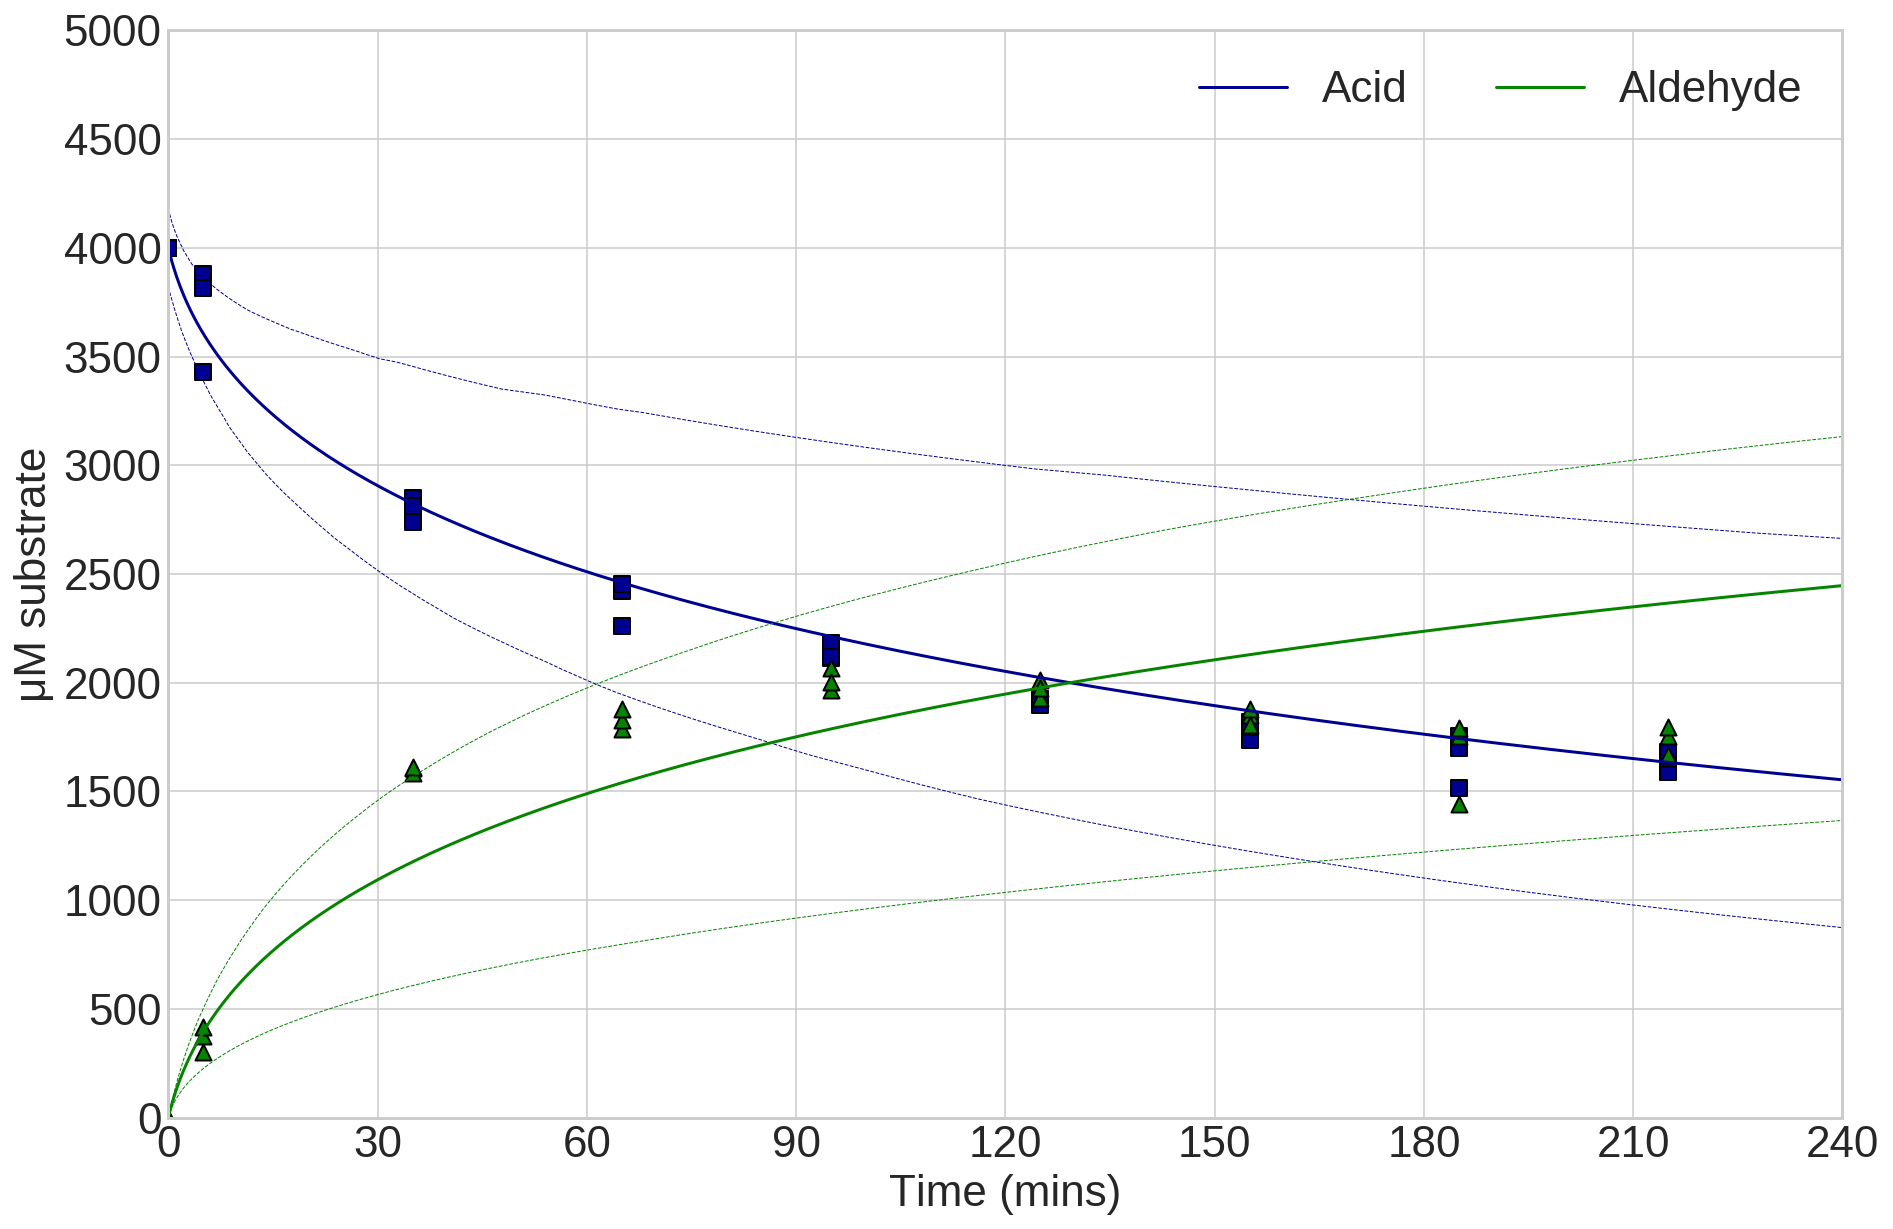

In [0]:
# Plot the model vs experimental daya
substrates = ["Acid", "Aldehyde"]
setup_graph(y_max=5000, x_max=240)
lines = add_ua_model_to_graph(substrates, ua.substrate_dataframes)
exp_data = pd.read_excel(data_url, 'car_only')
add_experimental_data_to_graph(substrates, exp_data)
plt.show()

# CAR + PPIase

In [0]:
#@title PPiase reaction {display-mode: "form"}
ppiase = kinetics.One_irr(kcat="ppi_kcat", kma="ppi_km",
                          a="PPi", enz="ppiase",
                          substrates=['PPi'], products=["PO4", "PO4"])

ppiase.parameter_bounds = {'ppi_kcat': (2200, 6600),
                           'ppi_km': (250, 750)}

In [0]:
# Define the model
model = kinetics.Model(logging=False)
model.append(car)
model.append(ppiase)

# Set the initial species concentrations in the model (in uM)
model.reaction_species.update({"car" : (1, 0.05),
                               'ppiase' : (1, 0.05),
                               "Acid" : (4000, 0.05),
                               "ATP" : (8000, 0.05),
                               "NADPH" : (5000, 0.05)})

# Set the model time: model.set_time(start, end, steps)
model.set_time(0, 240, 1000)
model.setup_model();

# Run the model as an uncertainty analysis
ua = kinetics.UA(model, num_samples=500, quartile_range=95, logging=True)
ua.run_standard_ua()

self.problem, self.samples and self.parsed_samples set by lhc
running all models


100%|██████████| 500/500 [00:22<00:00, 22.20it/s]


samples run, model outputs saved in self.output
quartiles calculated, saved in self.quartile_output
Quartiles for each substrate saved to self.substrate_dataframes


![CAR](https://github.com/willfinnigan/Seven_enzyme_biotransformation_2019/raw/master/figures/CAR_Ppiase.jpg)

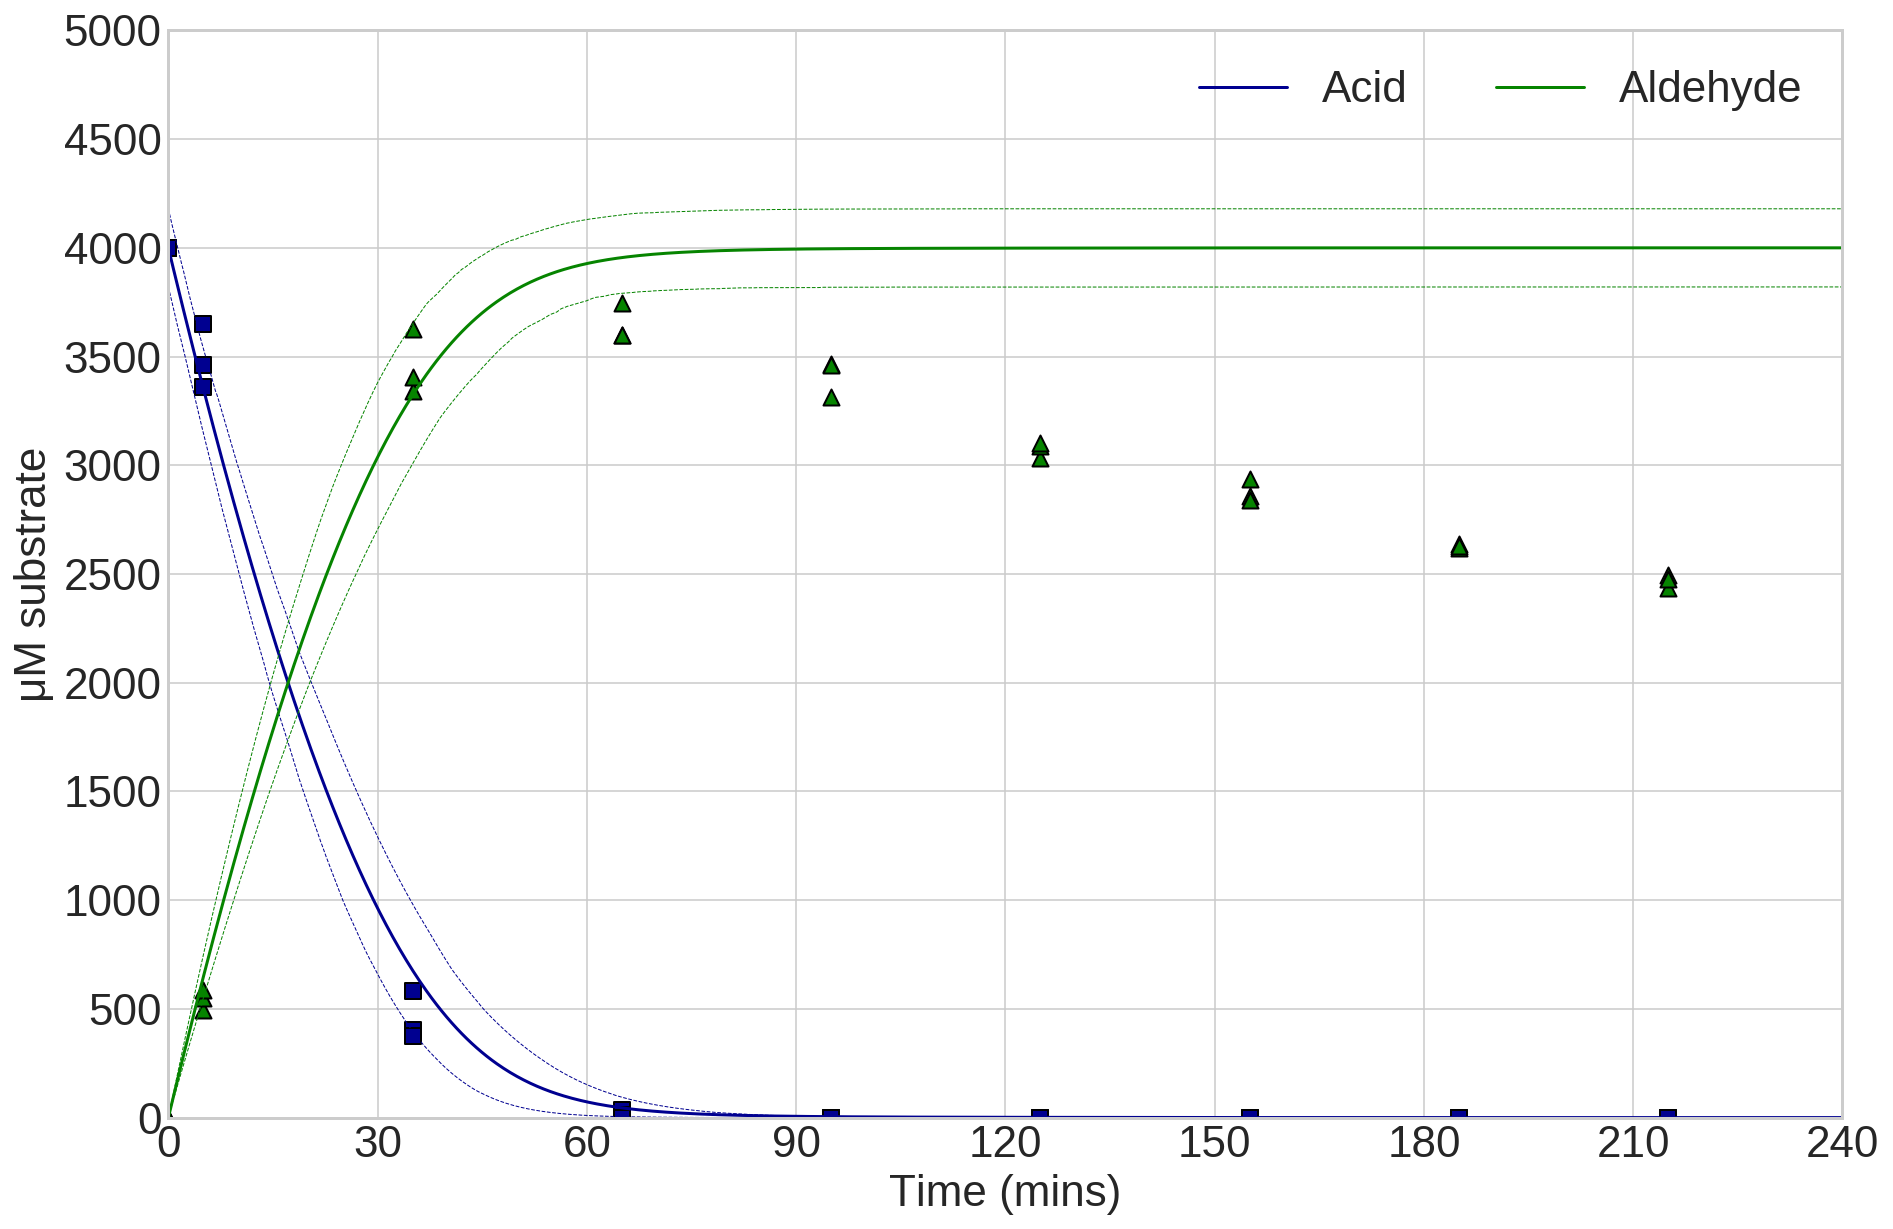

In [0]:
# Plot the model vs experimental daya
substrates = ["Acid", "Aldehyde"]
setup_graph(y_max=5000, x_max=240)
lines = add_ua_model_to_graph(substrates, ua.substrate_dataframes)
exp_data = pd.read_excel(data_url, 'car_ppiase')
add_experimental_data_to_graph(substrates, exp_data)
plt.show()

In [0]:
#@title Aldehyde reaction with Tris {display-mode: "form"}
aldehyde_degradation = kinetics.FirstOrderRate(k="aldehyde_degrad_k", a='Aldehyde',
                                               substrates=['Aldehyde'], products=['Aldehyde_Tris_product'])

aldehyde_degradation.parameter_bounds = {"aldehyde_degrad_k": (0.001395, 0.004185)}

In [0]:
# Define the model
model = kinetics.Model(logging=False)
model.append(car)
model.append(ppiase)
model.append(aldehyde_degradation)

# Set the initial species concentrations in the model (in uM)
model.reaction_species.update({"car" : (1, 0.05),
                               'ppiase' : (1, 0.05),
                               "Acid" : (4000, 0.05),
                               "ATP" : (8000, 0.05),
                               "NADPH" : (5000, 0.05)})

# Set the model time: model.set_time(start, end, steps)
model.set_time(0, 240, 1000)
model.setup_model();

# Run the model as an uncertainty analysis
ua = kinetics.UA(model, num_samples=500, quartile_range=95, logging=True)
ua.run_standard_ua()

self.problem, self.samples and self.parsed_samples set by lhc
running all models


100%|██████████| 500/500 [00:25<00:00, 19.70it/s]


samples run, model outputs saved in self.output
quartiles calculated, saved in self.quartile_output
Quartiles for each substrate saved to self.substrate_dataframes


![CAR](https://github.com/willfinnigan/Seven_enzyme_biotransformation_2019/raw/master/figures/CAR_Ppiase.jpg)

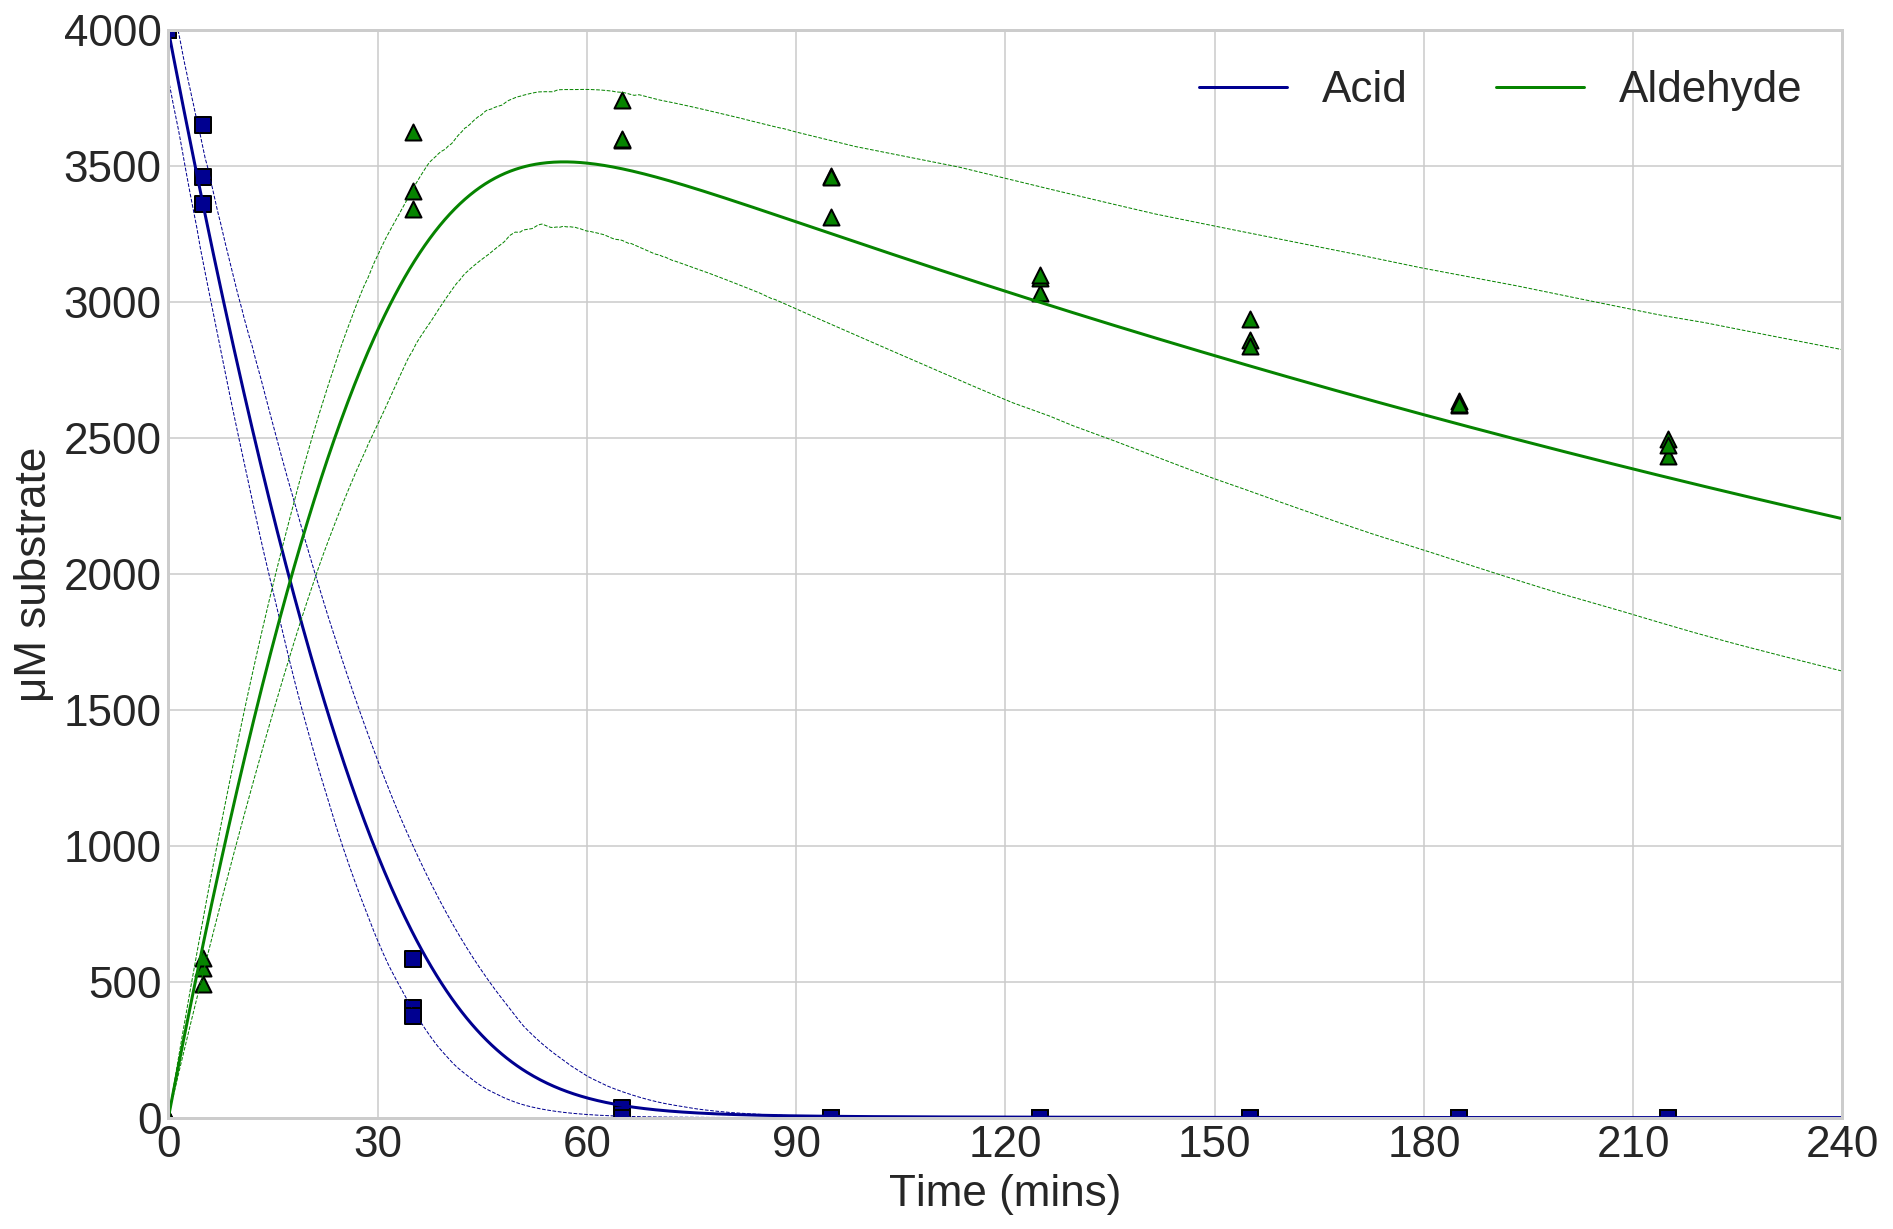

In [0]:
# Plot the model vs experimental daya
substrates = ["Acid", "Aldehyde"]
setup_graph(y_max=4000, x_max=240)
lines = add_ua_model_to_graph(substrates, ua.substrate_dataframes)
exp_data = pd.read_excel(data_url, 'car_ppiase')
add_experimental_data_to_graph(substrates, exp_data)
plt.show()

In [0]:
#@title PTDH reactions {display-mode: "form"}
ptdh_nad = kinetics.One_irr(kcat="ptdh_kcat_nad", kma="ptdh_km_nad",
                            a='NAD+', enz='ptdh',
                            substrates=['NAD+'], products=['NADH'])

ptdh_nad.parameter_bounds = {"ptdh_kcat_nad": (621, 653),
                             "ptdh_km_nad": (90, 110)}

ptdh_nadp = kinetics.One_irr(kcat="ptdh_kcat_nadp", kma="ptdh_km_nadp",
                            a='NADP+', enz='ptdh',
                            substrates=['NADP+'], products=['NADPH'])

ptdh_nadp.parameter_bounds = {"ptdh_kcat_nadp": (326, 358),
                             "ptdh_km_nadp": (180, 260)}


ptdh_nad.add_modifier(kinetics.CompetitiveInhibition(km="ptdh_km_nad", ki="ptdh_km_nadp", i="NADP+"))
ptdh_nadp.add_modifier(kinetics.CompetitiveInhibition(km="ptdh_km_nadp", ki="ptdh_km_nad", i="NAD+"))

In [0]:
# Define the model
model = kinetics.Model(logging=False)
model.append(car)
model.append(ppiase)
model.append(aldehyde_degradation)
model.append(ptdh_nad)
model.append(ptdh_nadp)

# Set the initial species concentrations in the model (in uM)
model.reaction_species.update({"car" : (1, 0.05),
                               'ppiase' : (1, 0.05),
                               'ptdh' : (1, 0.05),
                               "Acid" : (4000, 0.05),
                               "ATP" : (8000, 0.05),
                               "NADPH" : (500, 0.05),
                               "PO3" : (20000, 0.05)})

# Set the model time: model.set_time(start, end, steps)
model.set_time(0, 240, 1000)
model.setup_model();

# Run the model as an uncertainty analysis
ua = kinetics.UA(model, num_samples=500, quartile_range=95, logging=True)
ua.run_standard_ua()


self.problem, self.samples and self.parsed_samples set by lhc
running all models


100%|██████████| 500/500 [01:30<00:00,  6.31it/s]


samples run, model outputs saved in self.output
quartiles calculated, saved in self.quartile_output
Quartiles for each substrate saved to self.substrate_dataframes


![CAR](https://github.com/willfinnigan/Seven_enzyme_biotransformation_2019/raw/master/figures/CAR_Ppiase_PTDH.jpg)

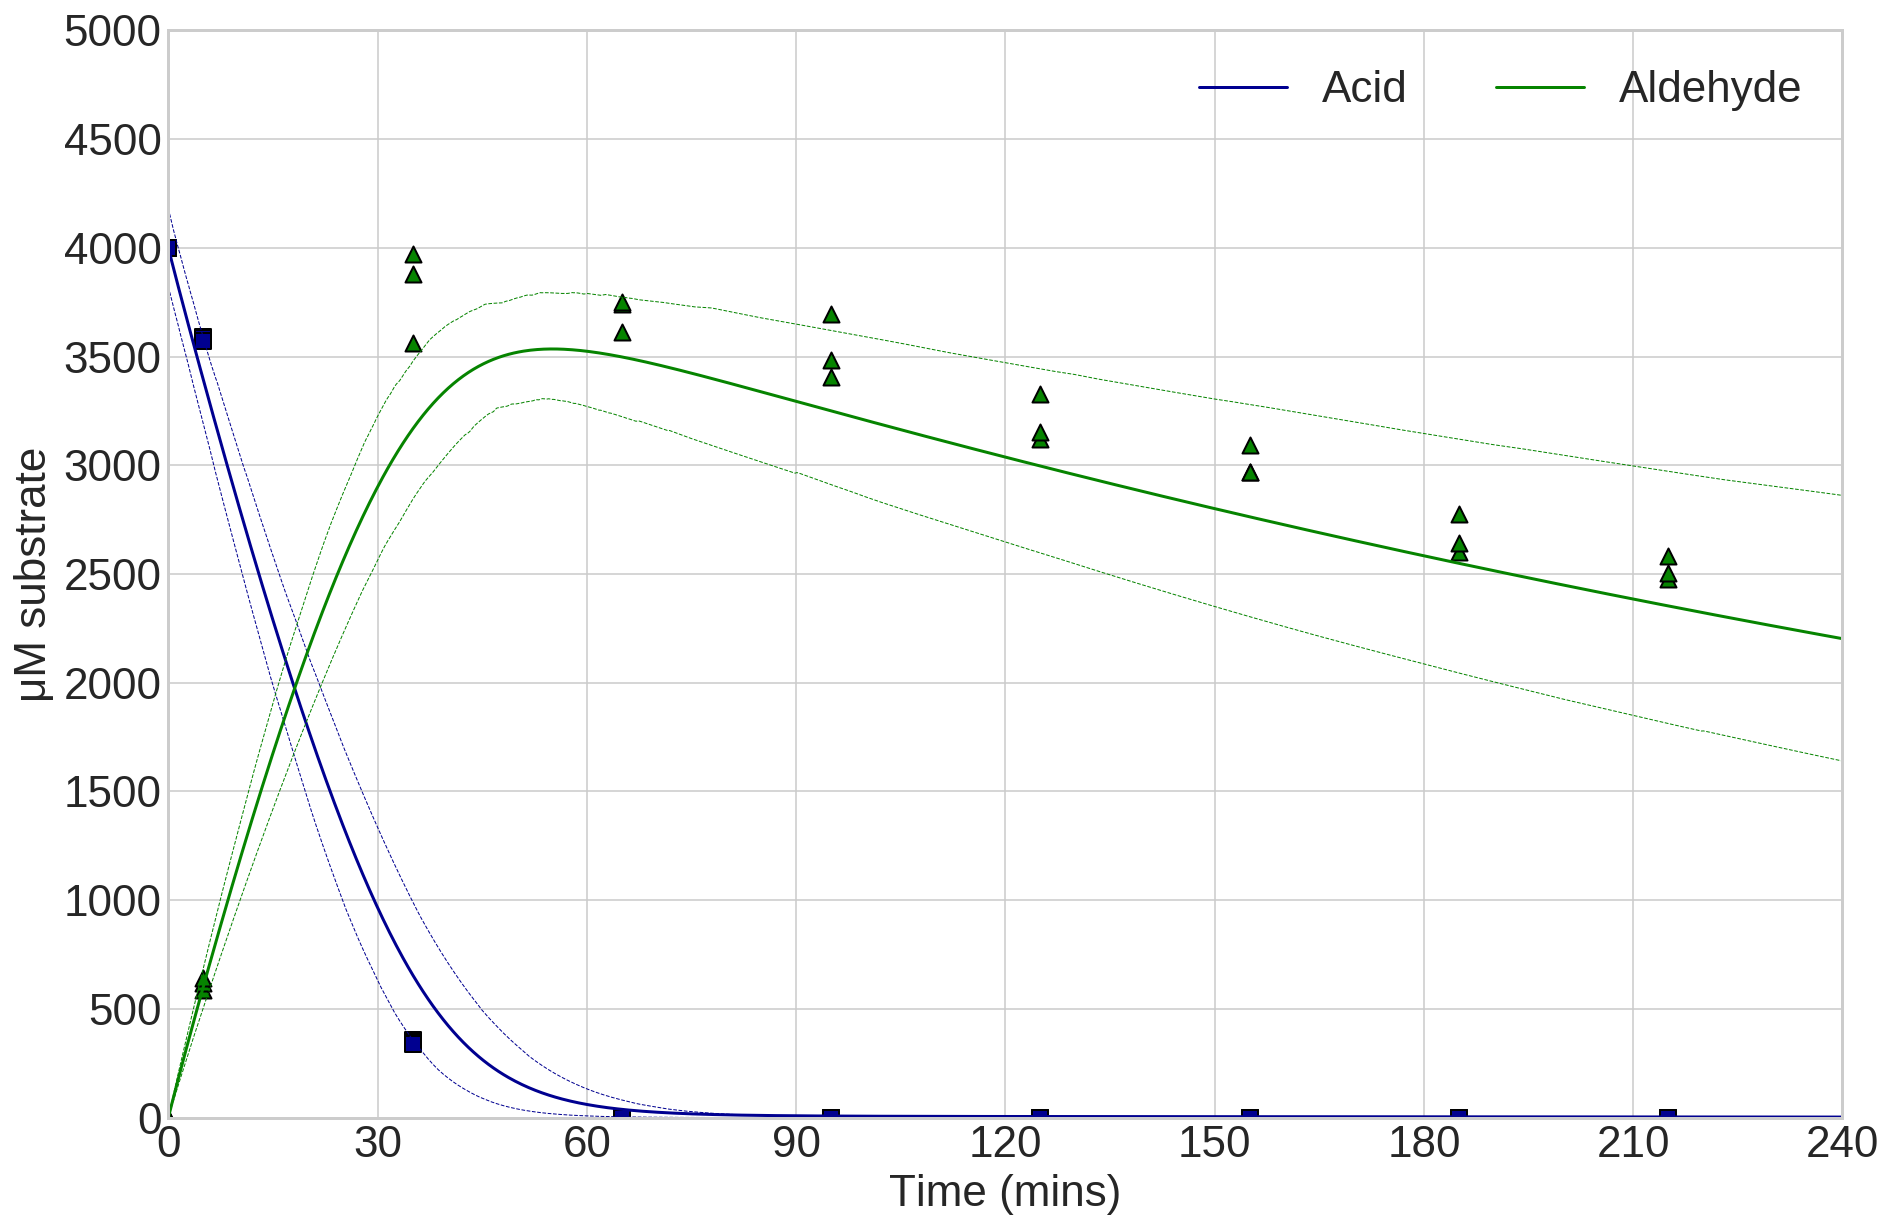

In [0]:
# Plot the model vs experimental daya
substrates = ["Acid", "Aldehyde"]
setup_graph(y_max=5000, x_max=240)
lines = add_ua_model_to_graph(substrates, ua.substrate_dataframes)
exp_data = pd.read_excel(data_url, 'car_ppiase_ptdh')
add_experimental_data_to_graph(substrates, exp_data)
plt.show()

In [0]:
#@title PAP reactions {display-mode: "form"}
pap_fwd = kinetics.Two_irr(kcat="pap_kcat_fwd", kma="pap_amp_km", kmb="pap_polyp_km",
                              a='AMP', b='PolyP', enz='pap',
                              substrates=['AMP', 'PolyP'], products=['ADP'])

pap_rev = kinetics.One_irr(kcat="pap_kcat_rev", kma="pap_adp_km",
                              a='ADP', enz='pap',
                              substrates=['ADP'], products=['AMP', 'PolyP'])

pap_fwd.parameter_bounds = {"pap_kcat_fwd": (125, 375),
                            "pap_amp_km": (140, 420),
                            "pap_polyp_km": (2000, 6000)}

pap_rev.parameter_bounds = {"pap_adp_km": (4150, 12450),  # From ref "Polyphosphate synthetic activity of polyphosphate..."
                            "pap_kcat_rev": (1.7, 5.1)}
                           

In [0]:
#@title AK reactions {display-mode: "form"}
ak_fwd = kinetics.Two_irr(kcat="ak_ampatp_kcat", kma="ak_mgatp_km", kmb="ak_amp_km",
                              a='ATP', b='AMP', enz='ak',
                              substrates=['ATP', 'AMP'], products=['ADP', 'ADP'])

ak_rev = kinetics.Two_irr(kcat="ak_adp_kcat", kma="ak_mgadp_km", kmb="ak_adp_km",
                              a='ADP', b='ADP', enz='ak',
                              substrates=['ADP', 'ADP'], products=['ATP', 'AMP'])



ak_fwd.parameter_bounds = {"ak_mgatp_km": (25.5, 76.5),
                           "ak_amp_km": (19, 57),
                           "ak_ampatp_kcat": (1975, 5925)}


ak_rev.parameter_bounds = {"ak_adp_km": (45.5, 136.5),
                           "ak_mgadp_km": (45.5, 136.5),
                           "ak_adp_kcat": (1170, 3510)}

In [0]:
# Define the model
model = kinetics.Model(logging=False)
model.append(car)
model.append(ppiase)
model.append(aldehyde_degradation)
model.append(ptdh_nad)
model.append(ptdh_nadp)
model.append(pap_fwd)
model.append(pap_rev)
model.append(ak_fwd)
model.append(ak_rev)

# Set the initial species concentrations in the model (in uM)
model.reaction_species.update({"car" : (1, 0.05),
                               'ppiase' : (1, 0.05),
                               'ptdh' : (1, 0.05),
                               'ak' : (1, 0.05),
                               'pap' : (3, 0.05),
                               "Acid" : (4500, 0.05),
                               "ATP" : (1250, 0.05),
                               "NADPH" : (500, 0.05),
                               "PO3" : (20000, 0.05),
                               "PolyP" : (6000, 0.25)})

# Set the model time: model.set_time(start, end, steps)
model.set_time(0, 240, 1000)
model.setup_model();

# Run the model as an uncertainty analysis
ua = kinetics.UA(model, num_samples=500, quartile_range=95, logging=True)
ua.run_standard_ua()

self.problem, self.samples and self.parsed_samples set by lhc
running all models


100%|██████████| 500/500 [04:23<00:00,  1.99it/s]


samples run, model outputs saved in self.output
quartiles calculated, saved in self.quartile_output
Quartiles for each substrate saved to self.substrate_dataframes


![CAR](https://github.com/willfinnigan/Seven_enzyme_biotransformation_2019/raw/master/figures/CAR_all.jpg)



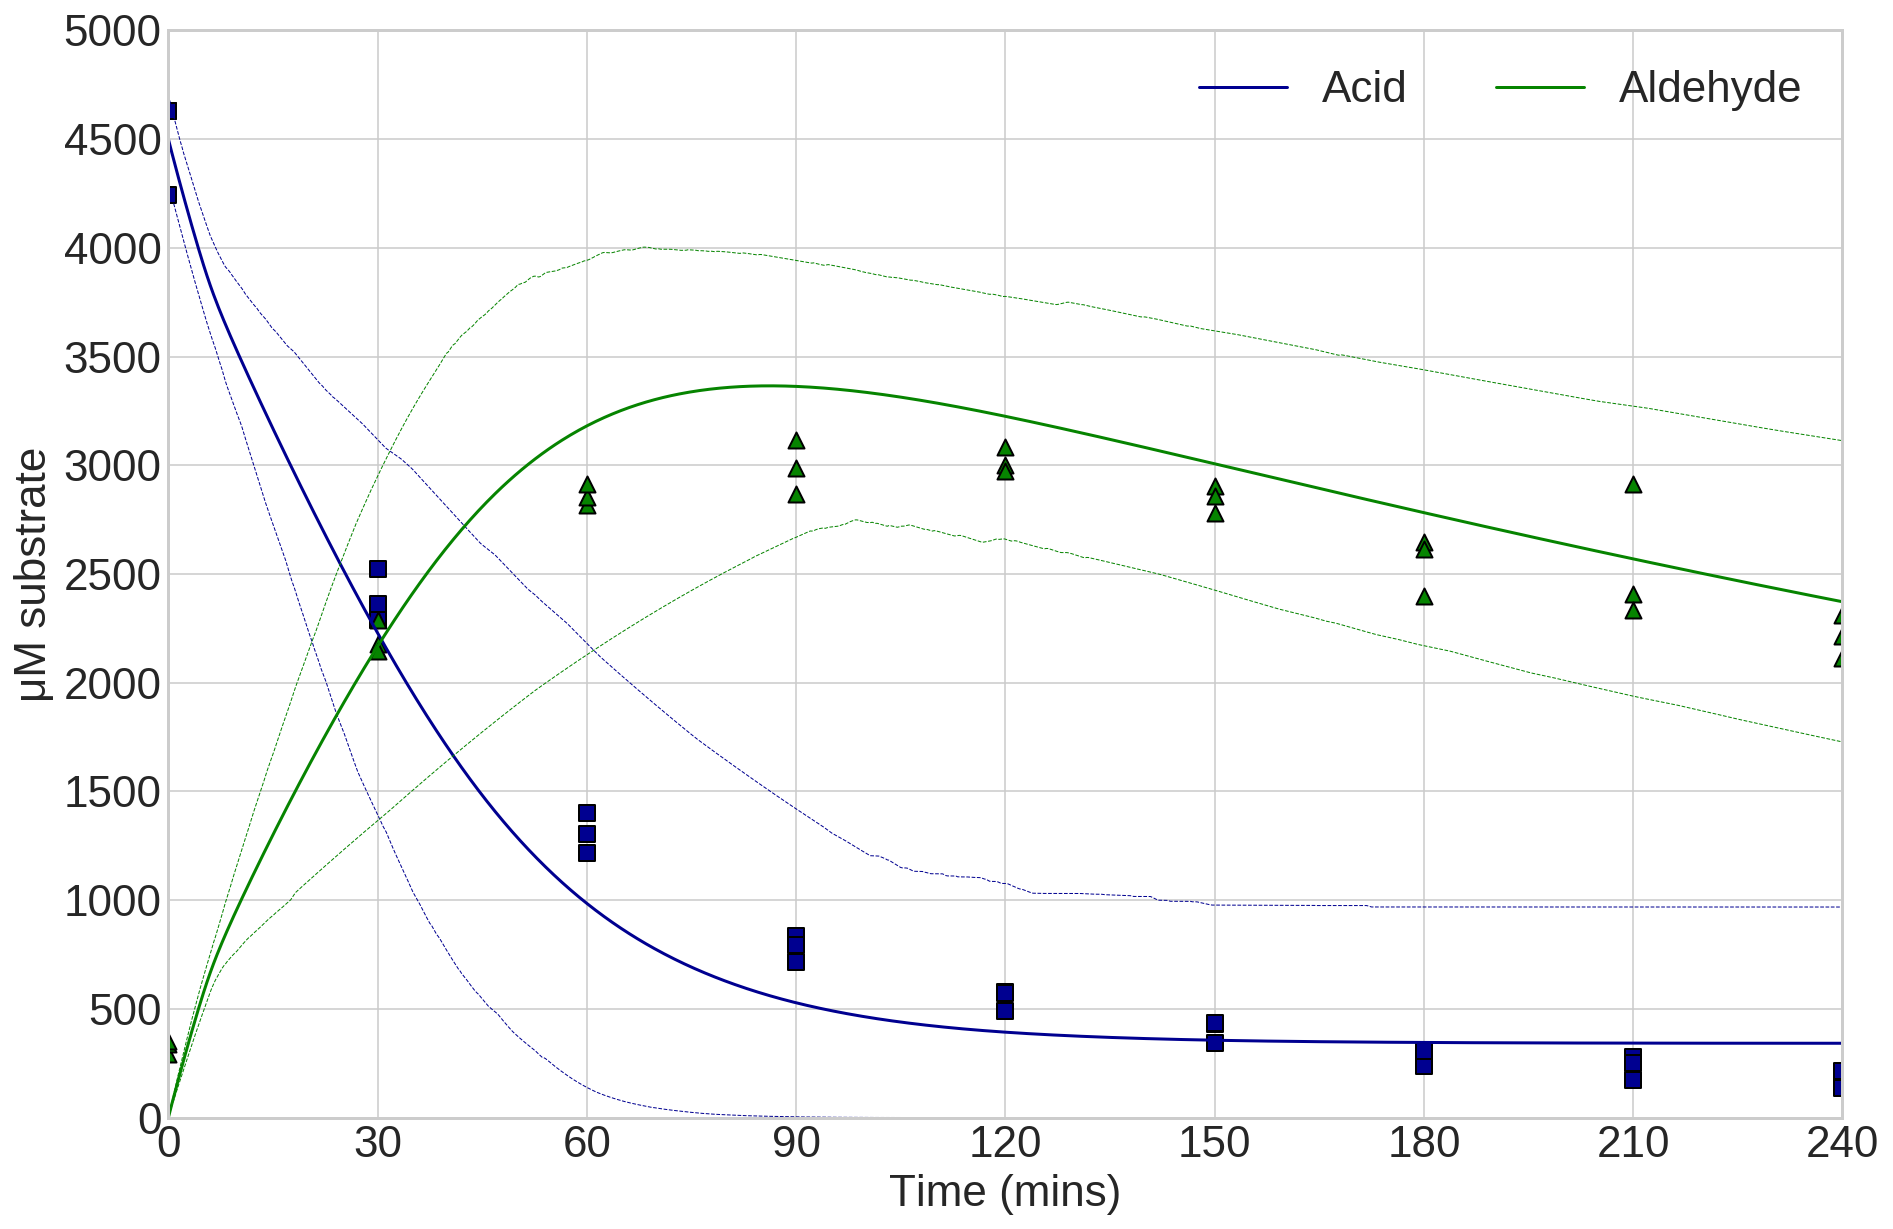

In [0]:
# Plot the model vs experimental daya
substrates = ["Acid", "Aldehyde"]
setup_graph(y_max=5000, x_max=240)
lines = add_ua_model_to_graph(substrates, ua.substrate_dataframes)
exp_data = pd.read_excel(data_url, 'car_ppiase_ptdh_ak_pap')
add_experimental_data_to_graph(substrates, exp_data)
plt.show()